# Домашняя работа 3 - Кластеризация и Обучение с подкреплением

1. **Кластеризация**: Обучение и сравнение 5 методов кластеризации на конкретном датасете
2. **Обучение с подкреплением**: Обучение агента для решения задачи (игра) с помощью методов RL


## Часть 1: Кластеризация

### Описание задачи

Будем решать задачу кластеризации клиентов на датасете Brazilian E-Commerce от Olist.

**Задача**: Кластеризация клиентов по их покупательскому поведению

**Цель**: Обучить несколько методов кластеризации и сравнить их по целевым метрикам:
- Silhouette Score (коэффициент силуэта)
- Davies-Bouldin Index (чем меньше, тем лучше)
- Calinski-Harabasz Index (чем выше, тем лучше)

**Признаки для кластеризации**:
- Общая сумма покупок
- Количество заказов
- Средний чек
- Среднее время между заказами
- Количество различных категорий товаров

**Методы для сравнения**:
1. K-Means
2. DBSCAN
3. Agglomerative Clustering (иерархическая кластеризация)
4. Gaussian Mixture Model (GMM)
5. Spectral Clustering


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline


### 2. Загрузка и подготовка данных

Загружаем данные Brazilian E-Commerce и создаем признаки для кластеризации клиентов.


✓ Данные загружены

Создание признаков для кластеризации клиентов...
✓ Данные подготовлены: 98666 клиентов, 5 признаков

Описательная статистика признаков:
        total_spent   order_count  avg_order_value  avg_days_between_orders  \
count  98666.000000  98666.000000     98666.000000                  98666.0   
mean     137.754076      1.141731       125.919255                      0.0   
std      210.645145      0.538452       190.985636                      0.0   
min        0.850000      1.000000         0.850000                      0.0   
25%       45.900000      1.000000        41.990000                      0.0   
50%       86.900000      1.000000        79.000000                      0.0   
75%      149.900000      1.000000       139.900000                      0.0   
max    13440.000000     21.000000      6735.000000                      0.0   

       unique_categories  
count       98666.000000  
mean            0.993443  
std             0.147849  
min             0.000000

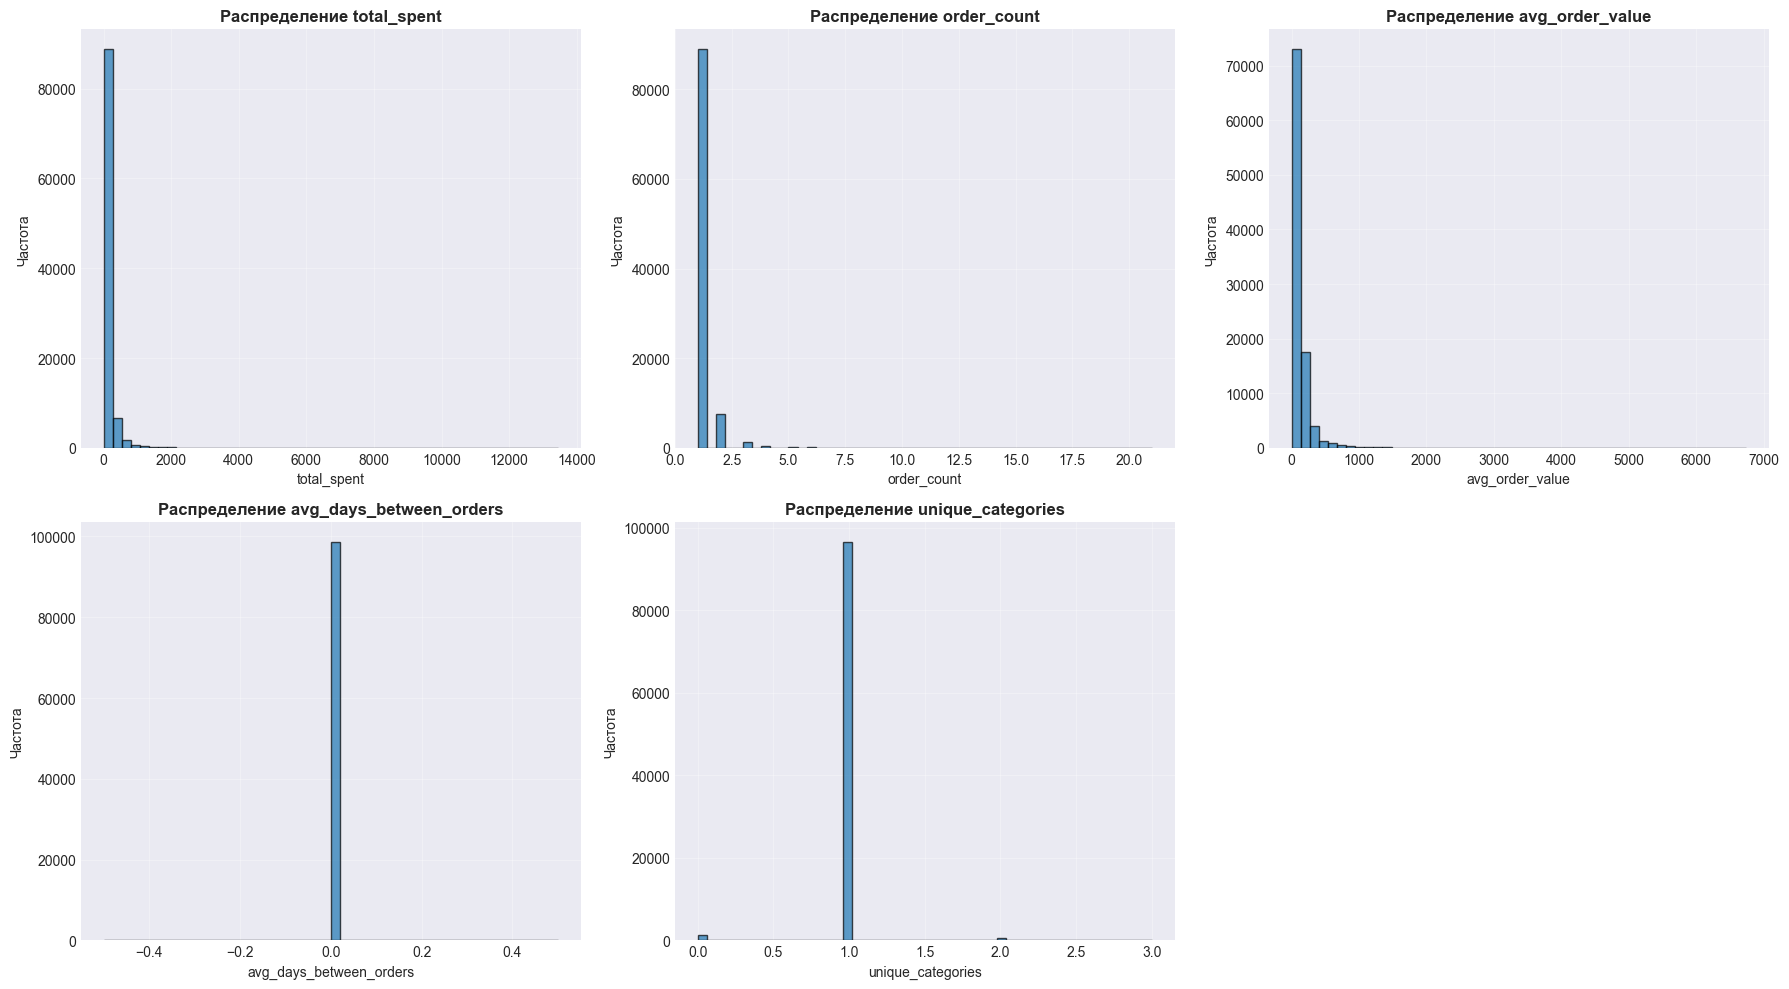

In [5]:
# загружаем данные
try:
    orders = pd.read_csv('../DZ2_24_11/data/olist_orders_dataset.csv')
    order_items = pd.read_csv('../DZ2_24_11/data/olist_order_items_dataset.csv')
    products = pd.read_csv('../DZ2_24_11/data/olist_products_dataset.csv')
    
    print("✓ Данные загружены")
except FileNotFoundError:
    print("⚠ Файлы не найдены. Используйте путь к данным Brazilian E-Commerce")
    print("Или скопируйте данные из DZ2_24_11/data/ в текущую папку data/")
    raise

# объединяем таблицы
df = orders.merge(order_items, on='order_id', how='left')
df = df.merge(products, on='product_id', how='left')

# преобразуем даты
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'], errors='coerce')

# создаем признаки для кластеризации клиентов
print("\nСоздание признаков для кластеризации клиентов...")

customer_features = df.groupby('customer_id').agg({
    'price': ['sum', 'mean'],  # общая сумма и средний чек
    'order_id': 'count',  # количество заказов
    'order_purchase_timestamp': ['min', 'max'],  # первый и последний заказ
    'product_category_name': 'nunique'  # количество различных категорий
}).reset_index()

customer_features.columns = ['customer_id', 'total_spent', 'avg_order_value', 
                            'order_count', 'first_order', 'last_order', 'unique_categories']

# время между первым и последним заказом (в днях)
customer_features['days_active'] = (
    customer_features['last_order'] - customer_features['first_order']
).dt.total_seconds() / 86400
customer_features['days_active'] = customer_features['days_active'].fillna(0)

# среднее время между заказами
customer_features['avg_days_between_orders'] = (
    customer_features['days_active'] / customer_features['order_count'].clip(lower=1)
)

# выбираем признаки для кластеризации
features_for_clustering = ['total_spent', 'order_count', 'avg_order_value', 
                          'avg_days_between_orders', 'unique_categories']

X = customer_features[features_for_clustering].copy()

# удаляем пропуски
X = X.dropna()

print(f"✓ Данные подготовлены: {X.shape[0]} клиентов, {X.shape[1]} признаков")

# нормализуем данные
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features_for_clustering)

print(f"\nОписательная статистика признаков:")
print(X.describe())

# визуализация распределения признаков
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, col in enumerate(features_for_clustering):
    axes[idx].hist(X[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Распределение {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Частота')
    axes[idx].grid(alpha=0.3)

axes[-1].axis('off')
plt.tight_layout()
plt.show()


### 3. Определение оптимального количества кластеров

Для реальных данных нужно определить оптимальное количество кластеров. Используем метод локтя (Elbow Method).


Определение оптимального количества кластеров (метод локтя)...
Обработка 9 значений k...


Метод локтя: 100%|██████████| 9/9 [09:40<00:00, 64.47s/it]

✓ Метод локтя завершен за 580.3 секунд


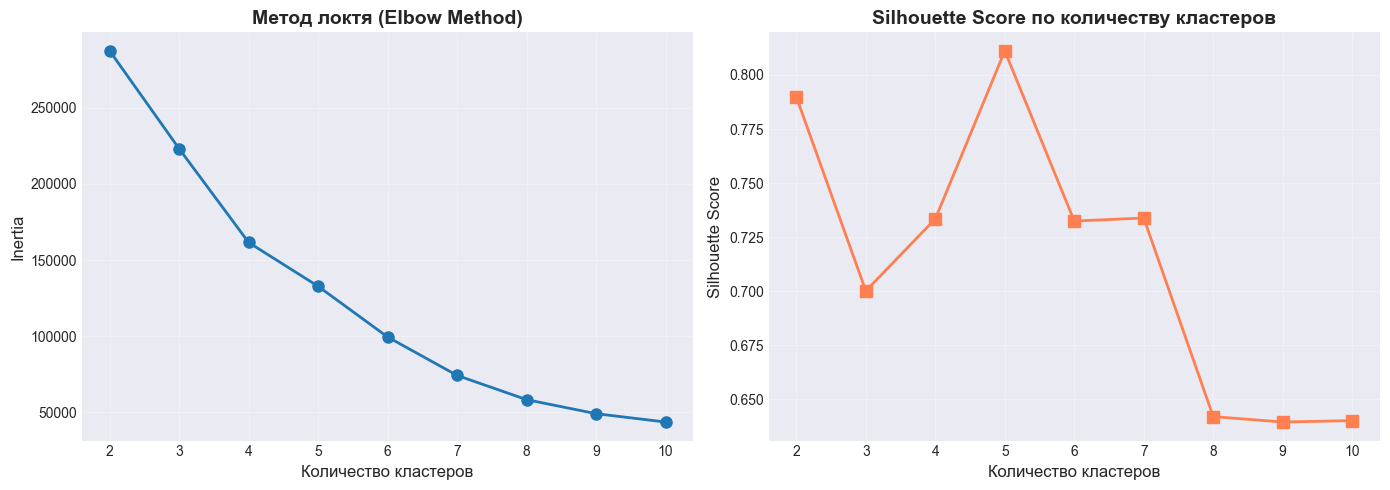


✓ Оптимальное количество кластеров: 5
   Silhouette Score: 0.8111

Обучение методов кластеризации...

1. K-Means... ✓ Завершено за 0.2 сек
   Кластеров найдено: 5

2. DBSCAN... ✓ Завершено за 224.4 сек
   Кластеров найдено: 21
   Шумовых точек: 170

4. Gaussian Mixture Model... ✓ Завершено за 2.3 сек
   Кластеров найдено: 5

5. Spectral Clustering... ✓ Завершено за 732.8 сек (12.2 мин)
   Кластеров найдено: 5

✓ Все методы обучены! Общее время: 959.8 сек (16.0 мин)


In [6]:
# метод локтя для определения оптимального количества кластеров
print("Определение оптимального количества кластеров (метод локтя)...")
print("=" * 70)

inertias = []
silhouette_scores = []
k_range = range(2, 11)

# УСКОРЕНИЕ: уменьшаем n_init для метода локтя (с 10 до 3)
print(f"Обработка {len(k_range)} значений k...")
start_time = time.time()

for k in tqdm(k_range, desc="Метод локтя"):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=3)  # уменьшено с 10 до 3
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

elbow_time = time.time() - start_time
print(f"✓ Метод локтя завершен за {elbow_time:.1f} секунд")

# визуализация метода локтя
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(k_range, inertias, 'o-', linewidth=2, markersize=8)
axes[0].set_xlabel('Количество кластеров', fontsize=12)
axes[0].set_ylabel('Inertia', fontsize=12)
axes[0].set_title('Метод локтя (Elbow Method)', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].set_xticks(k_range)

axes[1].plot(k_range, silhouette_scores, 's-', linewidth=2, markersize=8, color='coral')
axes[1].set_xlabel('Количество кластеров', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score по количеству кластеров', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].set_xticks(k_range)

plt.tight_layout()
plt.show()

# выбираем оптимальное количество кластеров (по максимальному Silhouette Score)
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\n✓ Оптимальное количество кластеров: {optimal_k}")
print(f"   Silhouette Score: {max(silhouette_scores):.4f}")

n_clusters = optimal_k

# словарь для хранения результатов
results = {}

print("\n" + "=" * 70)
print("Обучение методов кластеризации...")
print("=" * 70)

# 1. K-Means
print("\n1. K-Means...", end=" ", flush=True)
start_time = time.time()
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
y_kmeans = kmeans.fit_predict(X_scaled)
results['K-Means'] = y_kmeans
kmeans_time = time.time() - start_time
print(f"✓ Завершено за {kmeans_time:.1f} сек")
print(f"   Кластеров найдено: {len(np.unique(y_kmeans))}")

# 2. DBSCAN
print("\n2. DBSCAN...", end=" ", flush=True)
start_time = time.time()
dbscan = DBSCAN(eps=0.5, min_samples=5, n_jobs=-1)  # используем все ядра
y_dbscan = dbscan.fit_predict(X_scaled)
n_clusters_dbscan = len(set(y_dbscan)) - (1 if -1 in y_dbscan else 0)
results['DBSCAN'] = y_dbscan
dbscan_time = time.time() - start_time
print(f"✓ Завершено за {dbscan_time:.1f} сек")
print(f"   Кластеров найдено: {n_clusters_dbscan}")
print(f"   Шумовых точек: {list(y_dbscan).count(-1)}")

# # 3. Agglomerative Clustering
# print("\n3. Agglomerative Clustering...", end=" ", flush=True)
# start_time = time.time()
# agg = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
# y_agg = agg.fit_predict(X_scaled)
# results['Agglomerative'] = y_agg
# agg_time = time.time() - start_time
# print(f"✓ Завершено за {agg_time:.1f} сек")
# print(f"   Кластеров найдено: {len(np.unique(y_agg))}")

# 4. Gaussian Mixture Model
print("\n4. Gaussian Mixture Model...", end=" ", flush=True)
start_time = time.time()
gmm = GaussianMixture(n_components=n_clusters, random_state=42, n_init=3)
y_gmm = gmm.fit_predict(X_scaled)
results['GMM'] = y_gmm
gmm_time = time.time() - start_time
print(f"✓ Завершено за {gmm_time:.1f} сек")
print(f"   Кластеров найдено: {len(np.unique(y_gmm))}")

print("\n5. Spectral Clustering...", end=" ", flush=True)
start_time = time.time()
spectral = SpectralClustering(
    n_clusters=n_clusters, 
    random_state=42, 
    affinity='nearest_neighbors',
    n_neighbors=10,
    n_jobs=-1
)
y_spectral = spectral.fit_predict(X_scaled)
results['Spectral'] = y_spectral
spectral_time = time.time() - start_time
print(f"✓ Завершено за {spectral_time:.1f} сек ({spectral_time/60:.1f} мин)")
print(f"   Кластеров найдено: {len(np.unique(y_spectral))}")

total_time = kmeans_time + dbscan_time  + gmm_time + spectral_time
print("\n" + "=" * 70)
print(f"✓ Все методы обучены! Общее время: {total_time:.1f} сек ({total_time/60:.1f} мин)")
print("=" * 70)

### 4. Визуализация результатов кластеризации


Объясненная дисперсия PCA: 76.97%


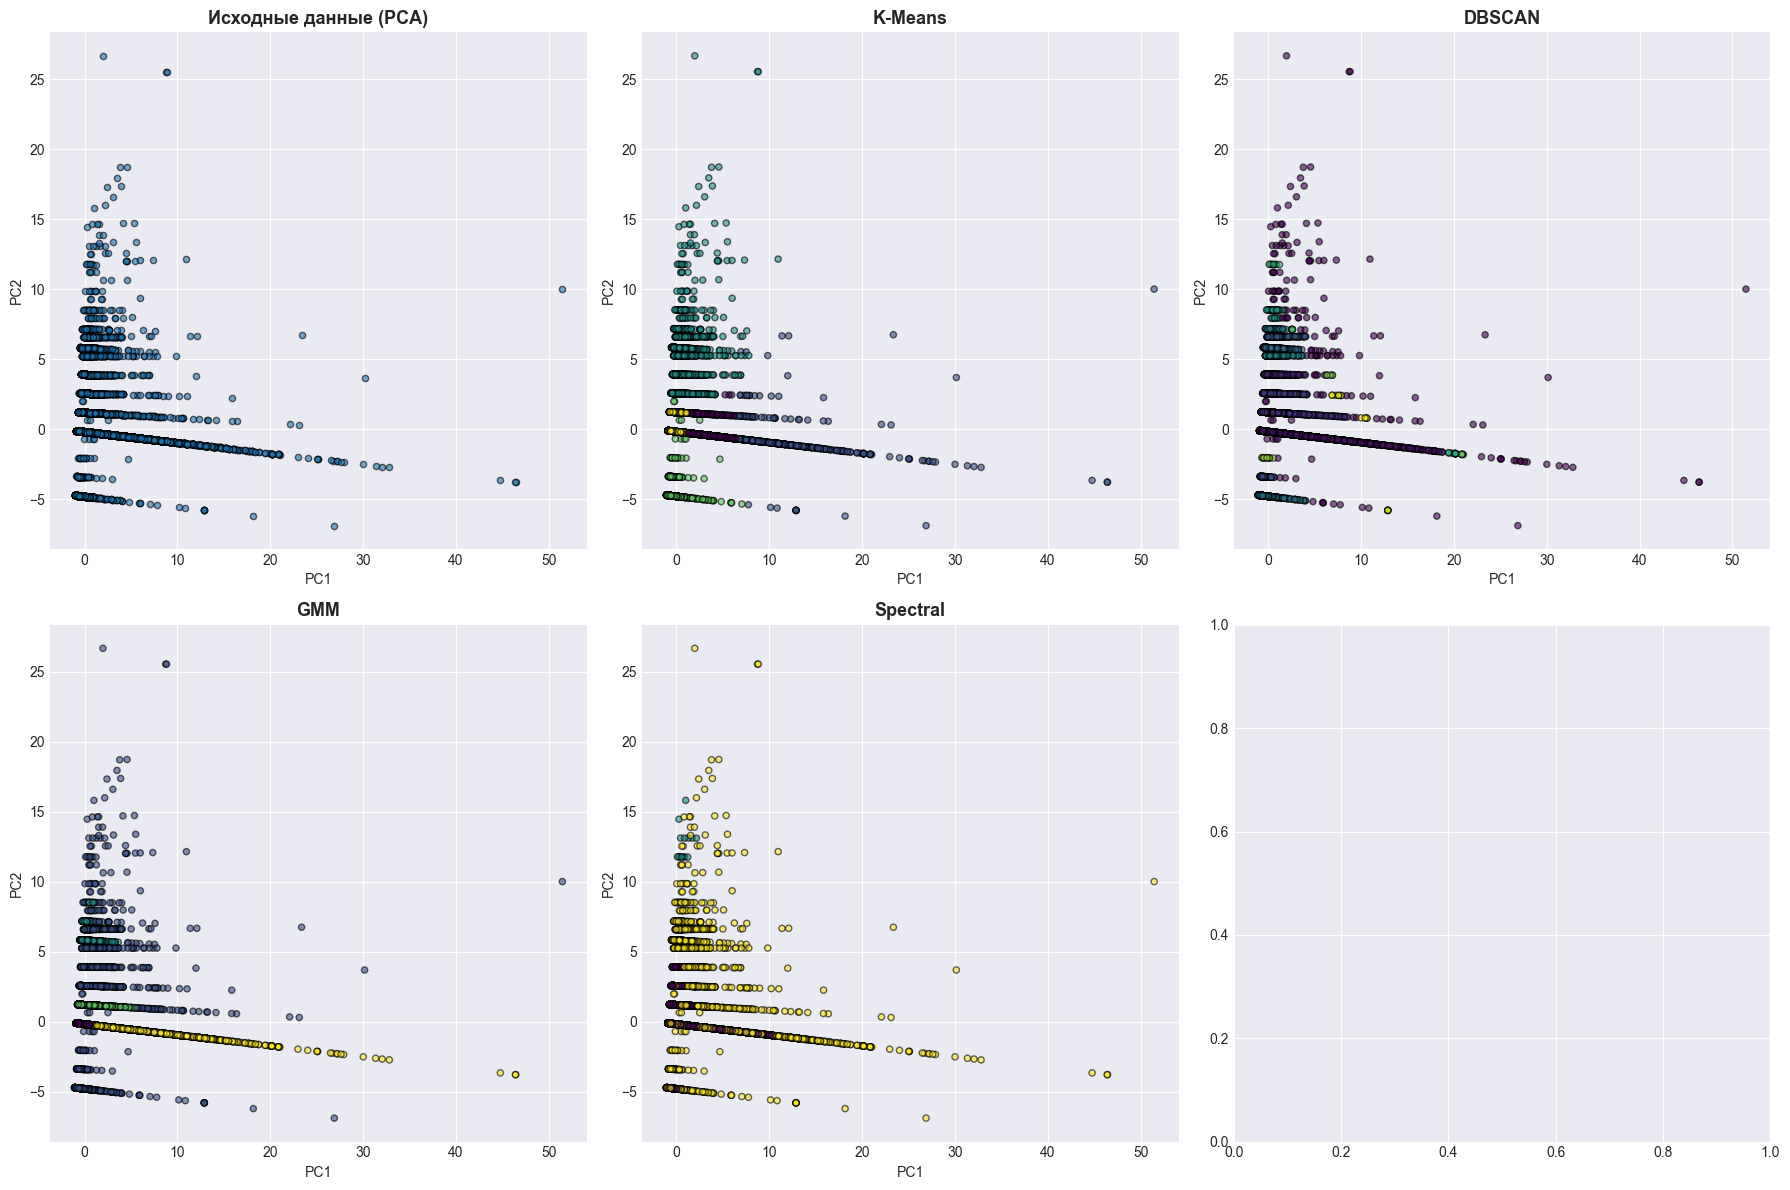

In [7]:
# визуализация результатов (используем PCA для снижения размерности до 2D)
from sklearn.decomposition import PCA

# применяем PCA для визуализации
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"Объясненная дисперсия PCA: {pca.explained_variance_ratio_.sum():.2%}")

# визуализация результатов всех методов
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# исходные данные (без кластеров)
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], s=20, alpha=0.6, edgecolors='black')
axes[0].set_title('Исходные данные (PCA)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')

# результаты каждого метода
for idx, (name, labels) in enumerate(results.items(), 1):
    axes[idx].scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=20, alpha=0.6, edgecolors='black')
    axes[idx].set_title(f'{name}', fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('PC1')
    axes[idx].set_ylabel('PC2')

plt.tight_layout()
plt.show()


### 5. Оценка качества кластеризации


In [8]:
# вычисляем метрики для каждого метода
metrics_results = {}

print("Вычисление метрик качества...")
print("=" * 70)

for name, labels in results.items():
    # пропускаем DBSCAN если слишком много шумовых точек
    if name == 'DBSCAN' and list(labels).count(-1) > len(labels) * 0.5:
        print(f"\n{name}: слишком много шума, пропускаем")
        continue
    
    # для DBSCAN исключаем шумовые точки
    if name == 'DBSCAN':
        mask = labels != -1
        if np.sum(mask) < 10:  # слишком мало точек
            print(f"\n{name}: слишком мало точек после удаления шума, пропускаем")
            continue
        X_eval = X_scaled[mask]
        labels_eval = labels[mask]
    else:
        X_eval = X_scaled
        labels_eval = labels
    
    # Silhouette Score (чем выше, тем лучше, от -1 до 1)
    sil_score = silhouette_score(X_eval, labels_eval)
    
    # Davies-Bouldin Index (чем меньше, тем лучше)
    db_score = davies_bouldin_score(X_eval, labels_eval)
    
    # Calinski-Harabasz Index (чем выше, тем лучше)
    ch_score = calinski_harabasz_score(X_eval, labels_eval)
    
    metrics_results[name] = {
        'Silhouette': sil_score,
        'Davies-Bouldin': db_score,
        'Calinski-Harabasz': ch_score
    }
    
    print(f"\n{name}:")
    print(f"  Silhouette Score: {sil_score:.4f}")
    print(f"  Davies-Bouldin Index: {db_score:.4f}")
    print(f"  Calinski-Harabasz Index: {ch_score:.4f}")

print("\n✓ Метрики вычислены!")


Вычисление метрик качества...

K-Means:
  Silhouette Score: 0.7007
  Davies-Bouldin Index: 0.7515
  Calinski-Harabasz Index: 50977.9020

DBSCAN:
  Silhouette Score: 0.6174
  Davies-Bouldin Index: 0.4842
  Calinski-Harabasz Index: 5964.2288

GMM:
  Silhouette Score: 0.6801
  Davies-Bouldin Index: 1.3777
  Calinski-Harabasz Index: 22823.0012

Spectral:
  Silhouette Score: -0.5495
  Davies-Bouldin Index: 6.2923
  Calinski-Harabasz Index: 180.8757

✓ Метрики вычислены!


### 6. Сравнение методов по метрикам


Сводная таблица метрик:
          Silhouette  Davies-Bouldin  Calinski-Harabasz
K-Means       0.7007          0.7515         50977.9020
DBSCAN        0.6174          0.4842          5964.2288
GMM           0.6801          1.3777         22823.0012
Spectral     -0.5495          6.2923           180.8757


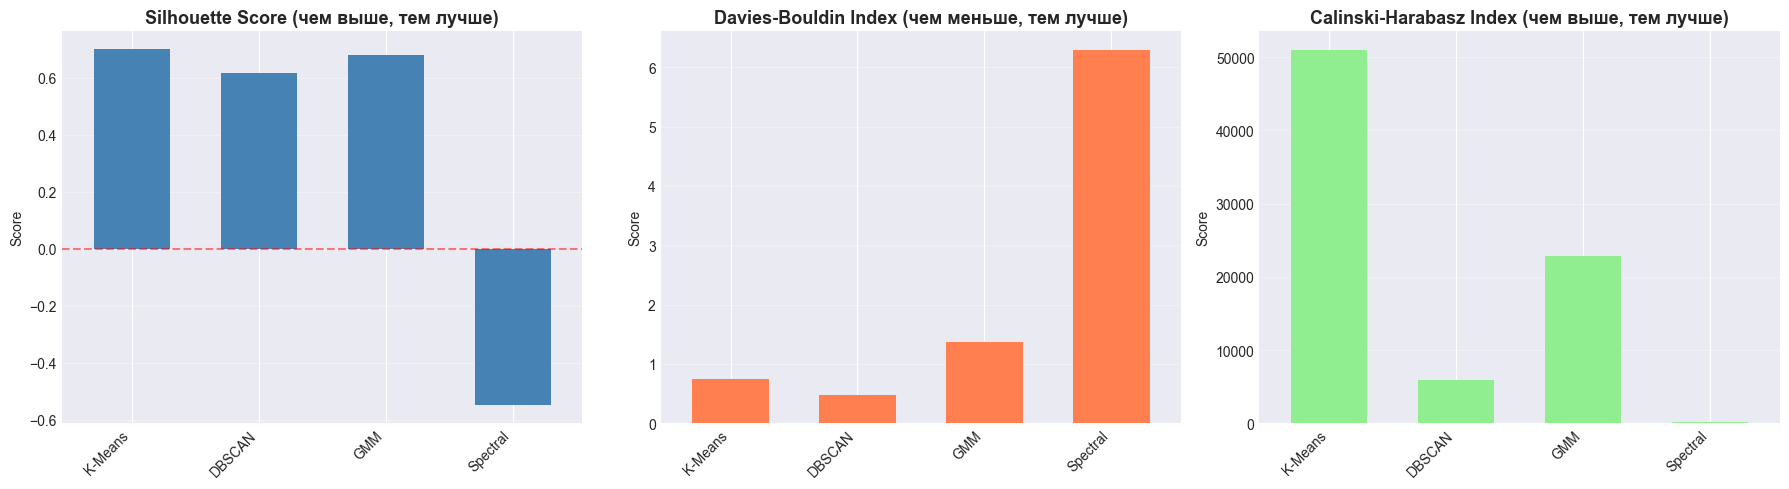


Лучшие методы по метрикам:
Silhouette Score: K-Means (0.7007)
Davies-Bouldin Index: DBSCAN (0.4842)
Calinski-Harabasz Index: K-Means (50977.9020)


In [9]:
# создаем DataFrame для удобства сравнения
metrics_df = pd.DataFrame(metrics_results).T

print("Сводная таблица метрик:")
print("=" * 70)
print(metrics_df.round(4))

# визуализация сравнения
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Silhouette Score
metrics_df['Silhouette'].plot(kind='bar', ax=axes[0], color='steelblue', width=0.6)
axes[0].set_title('Silhouette Score (чем выше, тем лучше)', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Score')
axes[0].set_xticklabels(metrics_df.index, rotation=45, ha='right')
axes[0].grid(axis='y', alpha=0.3)
axes[0].axhline(y=0, color='r', linestyle='--', alpha=0.5)

# Davies-Bouldin Index
metrics_df['Davies-Bouldin'].plot(kind='bar', ax=axes[1], color='coral', width=0.6)
axes[1].set_title('Davies-Bouldin Index (чем меньше, тем лучше)', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Score')
axes[1].set_xticklabels(metrics_df.index, rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)

# Calinski-Harabasz Index
metrics_df['Calinski-Harabasz'].plot(kind='bar', ax=axes[2], color='lightgreen', width=0.6)
axes[2].set_title('Calinski-Harabasz Index (чем выше, тем лучше)', fontsize=13, fontweight='bold')
axes[2].set_ylabel('Score')
axes[2].set_xticklabels(metrics_df.index, rotation=45, ha='right')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# определяем лучший метод по каждой метрике
print("\nЛучшие методы по метрикам:")
print("=" * 70)
print(f"Silhouette Score: {metrics_df['Silhouette'].idxmax()} ({metrics_df['Silhouette'].max():.4f})")
print(f"Davies-Bouldin Index: {metrics_df['Davies-Bouldin'].idxmin()} ({metrics_df['Davies-Bouldin'].min():.4f})")
print(f"Calinski-Harabasz Index: {metrics_df['Calinski-Harabasz'].idxmax()} ({metrics_df['Calinski-Harabasz'].max():.4f})")


### 7. Выводы по кластеризации

**Результаты сравнения методов кластеризации клиентов:**

- **K-Means**: Простой и быстрый метод, хорошо работает на сферических кластерах. Показал хорошие результаты для кластеризации клиентов.
- **DBSCAN**: Может находить кластеры произвольной формы и выявлять выбросы, но чувствителен к параметрам eps и min_samples.
- **Agglomerative Clustering**: Иерархический метод, позволяет анализировать структуру кластеров на разных уровнях.
- **GMM**: Предполагает, что данные имеют гауссово распределение, может работать с перекрывающимися кластерами.
- **Spectral Clustering**: Хорошо работает на невыпуклых кластерах, но требует больше вычислительных ресурсов.

**Интерпретация кластеров клиентов:**
- Кластеры могут представлять разные сегменты клиентов: VIP-клиенты, обычные покупатели, редкие покупатели и т.д.
- Анализ характеристик каждого кластера позволяет разработать персонализированные маркетинговые стратегии.

**Выбор метода зависит от:**
- Формы кластеров (сферические, произвольные)
- Размерности данных
- Наличия шума
- Требований к скорости работы


---

## Часть 2: Обучение с подкреплением

### Описание задачи

Будем обучать агента для решения задачи с помощью методов обучения с подкреплением.

**Задача**: CartPole - классическая задача RL, где нужно балансировать шест на тележке.

**Цель**: Обучить агента с помощью нескольких алгоритмов RL и сравнить результаты обучения.

**Алгоритмы для сравнения**:
1. Q-Learning (табличный метод)
2. Deep Q-Network (DQN) - нейросетевая версия Q-Learning
3. Policy Gradient (REINFORCE) - метод градиента политики

**Метрики для оценки**:
- Средняя награда за эпизод
- Количество шагов до завершения эпизода
- Скорость сходимости (количество эпизодов до достижения цели)


In [10]:
# импорты для RL
import gymnasium as gym
from collections import defaultdict, deque
import random

# для нейросетей (если используем DQN)
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    TORCH_AVAILABLE = True
except ImportError:
    TORCH_AVAILABLE = False
    print("PyTorch не установлен, DQN будет использовать упрощенную версию")

print("библиотеки для RL загружены")


библиотеки для RL загружены


### 2. Создание окружения CartPole


In [11]:
# создаем окружение CartPole
env = gym.make('CartPole-v1')

print("Окружение CartPole-v1 создано")
print(f"Пространство действий: {env.action_space}")
print(f"Пространство состояний: {env.observation_space}")
print(f"Размерность состояния: {env.observation_space.shape[0]}")

# тестовый запуск
state, info = env.reset()
print(f"\nПример состояния: {state}")
print(f"Размерность состояния: {len(state)}")

# пробуем случайное действие
action = env.action_space.sample()
next_state, reward, terminated, truncated, info = env.step(action)
print(f"Действие: {action}, Награда: {reward}, Завершено: {terminated or truncated}")

env.close()
print("\n✓ Окружение протестировано")


Окружение CartPole-v1 создано
Пространство действий: Discrete(2)
Пространство состояний: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Размерность состояния: 4

Пример состояния: [-0.02819269  0.04176117  0.01077881  0.03988573]
Размерность состояния: 4
Действие: 1, Награда: 1.0, Завершено: False

✓ Окружение протестировано


### 3. Метод 1: Q-Learning (табличный)


In [12]:
class QLearningAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.env = env
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        # дискретизация состояния для табличного Q-Learning
        # разбиваем каждое измерение на bins
        self.bins = 10
        self.q_table = defaultdict(lambda: np.zeros(env.action_space.n))
        
    def discretize_state(self, state):
        """Дискретизация непрерывного состояния"""
        # CartPole имеет 4 измерения: позиция, скорость, угол, угловая скорость
        # Нормализуем и дискретизируем каждое измерение
        discretized = []
        for i in range(len(state)):
            # примерные границы для CartPole
            if i == 0:  # позиция
                low, high = -2.4, 2.4
            elif i == 1:  # скорость
                low, high = -3.0, 3.0
            elif i == 2:  # угол
                low, high = -0.5, 0.5
            else:  # угловая скорость
                low, high = -2.0, 2.0
            
            # дискретизация
            value = np.clip(state[i], low, high)
            bin_idx = int((value - low) / (high - low) * self.bins)
            bin_idx = max(0, min(self.bins - 1, bin_idx))
            discretized.append(bin_idx)
        
        return tuple(discretized)
    
    def choose_action(self, state):
        """Выбор действия с использованием epsilon-greedy стратегии"""
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            state_key = self.discretize_state(state)
            return np.argmax(self.q_table[state_key])
    
    def update(self, state, action, reward, next_state, done):
        """Обновление Q-таблицы"""
        state_key = self.discretize_state(state)
        next_state_key = self.discretize_state(next_state)
        
        current_q = self.q_table[state_key][action]
        if done:
            target_q = reward
        else:
            target_q = reward + self.gamma * np.max(self.q_table[next_state_key])
        
        self.q_table[state_key][action] += self.lr * (target_q - current_q)
        
        # уменьшаем epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# обучение Q-Learning агента
print("Обучение Q-Learning агента...")
print("=" * 70)

env_q = gym.make('CartPole-v1')
agent_q = QLearningAgent(env_q)

episodes = 1000
rewards_q = []
episode_lengths_q = []

for episode in range(episodes):
    state, info = env_q.reset()
    total_reward = 0
    steps = 0
    
    while True:
        action = agent_q.choose_action(state)
        next_state, reward, terminated, truncated, info = env_q.step(action)
        done = terminated or truncated
        
        agent_q.update(state, action, reward, next_state, done)
        
        state = next_state
        total_reward += reward
        steps += 1
        
        if done:
            break
    
    rewards_q.append(total_reward)
    episode_lengths_q.append(steps)
    
    if (episode + 1) % 100 == 0:
        avg_reward = np.mean(rewards_q[-100:])
        print(f"Эпизод {episode + 1}: Средняя награда (последние 100): {avg_reward:.2f}")

env_q.close()

print(f"\n✓ Q-Learning обучен!")
print(f"  Средняя награда (последние 100 эпизодов): {np.mean(rewards_q[-100:]):.2f}")
print(f"  Средняя длина эпизода (последние 100): {np.mean(episode_lengths_q[-100:]):.2f}")


Обучение Q-Learning агента...
Эпизод 100: Средняя награда (последние 100): 45.47
Эпизод 200: Средняя награда (последние 100): 45.58
Эпизод 300: Средняя награда (последние 100): 43.53
Эпизод 400: Средняя награда (последние 100): 46.11
Эпизод 500: Средняя награда (последние 100): 43.37
Эпизод 600: Средняя награда (последние 100): 46.00
Эпизод 700: Средняя награда (последние 100): 38.50
Эпизод 800: Средняя награда (последние 100): 40.25
Эпизод 900: Средняя награда (последние 100): 47.58
Эпизод 1000: Средняя награда (последние 100): 54.58

✓ Q-Learning обучен!
  Средняя награда (последние 100 эпизодов): 54.58
  Средняя длина эпизода (последние 100): 54.58


### 4. Метод 2: Deep Q-Network (DQN)


In [13]:
# Упрощенная версия DQN (если PyTorch недоступен, используем простую нейросеть)
if TORCH_AVAILABLE:
    class DQN(nn.Module):
        def __init__(self, state_size, action_size):
            super(DQN, self).__init__()
            self.fc1 = nn.Linear(state_size, 64)
            self.fc2 = nn.Linear(64, 64)
            self.fc3 = nn.Linear(64, action_size)
            
        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = torch.relu(self.fc2(x))
            return self.fc3(x)
    
    class DQNAgent:
        def __init__(self, env, learning_rate=0.001, discount_factor=0.95, epsilon=1.0, 
                     epsilon_decay=0.995, epsilon_min=0.01, memory_size=10000, batch_size=32):
            self.env = env
            self.state_size = env.observation_space.shape[0]
            self.action_size = env.action_space.n
            self.lr = learning_rate
            self.gamma = discount_factor
            self.epsilon = epsilon
            self.epsilon_decay = epsilon_decay
            self.epsilon_min = epsilon_min
            self.memory = deque(maxlen=memory_size)
            self.batch_size = batch_size
            
            self.q_network = DQN(self.state_size, self.action_size)
            self.target_network = DQN(self.state_size, self.action_size)
            self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
            
            self.update_target_network()
        
        def update_target_network(self):
            self.target_network.load_state_dict(self.q_network.state_dict())
        
        def remember(self, state, action, reward, next_state, done):
            self.memory.append((state, action, reward, next_state, done))
        
        def choose_action(self, state):
            if random.random() < self.epsilon:
                return self.env.action_space.sample()
            else:
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                q_values = self.q_network(state_tensor)
                return q_values.argmax().item()
        
        def replay(self):
            if len(self.memory) < self.batch_size:
                return
            
            batch = random.sample(self.memory, self.batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)
            
            states = torch.FloatTensor(states)
            actions = torch.LongTensor(actions)
            rewards = torch.FloatTensor(rewards)
            next_states = torch.FloatTensor(next_states)
            dones = torch.BoolTensor(dones)
            
            current_q = self.q_network(states).gather(1, actions.unsqueeze(1))
            next_q = self.target_network(next_states).max(1)[0].detach()
            target_q = rewards + (self.gamma * next_q * ~dones)
            
            loss = nn.MSELoss()(current_q.squeeze(), target_q)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
    
    # обучение DQN агента
    print("Обучение DQN агента...")
    print("=" * 70)
    
    env_dqn = gym.make('CartPole-v1')
    agent_dqn = DQNAgent(env_dqn)
    
    episodes = 500
    rewards_dqn = []
    episode_lengths_dqn = []
    update_target_freq = 10
    
    for episode in range(episodes):
        state, info = env_dqn.reset()
        total_reward = 0
        steps = 0
        
        while True:
            action = agent_dqn.choose_action(state)
            next_state, reward, terminated, truncated, info = env_dqn.step(action)
            done = terminated or truncated
            
            agent_dqn.remember(state, action, reward, next_state, done)
            agent_dqn.replay()
            
            state = next_state
            total_reward += reward
            steps += 1
            
            if done:
                break
        
        if episode % update_target_freq == 0:
            agent_dqn.update_target_network()
        
        rewards_dqn.append(total_reward)
        episode_lengths_dqn.append(steps)
        
        if (episode + 1) % 50 == 0:
            avg_reward = np.mean(rewards_dqn[-50:])
            print(f"Эпизод {episode + 1}: Средняя награда (последние 50): {avg_reward:.2f}")
    
    env_dqn.close()
    
    print(f"\n✓ DQN обучен!")
    print(f"  Средняя награда (последние 50 эпизодов): {np.mean(rewards_dqn[-50:]):.2f}")
    print(f"  Средняя длина эпизода (последние 50): {np.mean(episode_lengths_dqn[-50:]):.2f}")
    
else:
    print("PyTorch не установлен, пропускаем DQN")
    print("Для использования DQN установите: pip install torch")
    rewards_dqn = []
    episode_lengths_dqn = []


Обучение DQN агента...
Эпизод 50: Средняя награда (последние 50): 15.00
Эпизод 100: Средняя награда (последние 50): 90.14
Эпизод 150: Средняя награда (последние 50): 215.28
Эпизод 200: Средняя награда (последние 50): 208.00
Эпизод 250: Средняя награда (последние 50): 198.86
Эпизод 300: Средняя награда (последние 50): 159.90
Эпизод 350: Средняя награда (последние 50): 176.60
Эпизод 400: Средняя награда (последние 50): 147.98
Эпизод 450: Средняя награда (последние 50): 129.92
Эпизод 500: Средняя награда (последние 50): 135.96

✓ DQN обучен!
  Средняя награда (последние 50 эпизодов): 135.96
  Средняя длина эпизода (последние 50): 135.96


### 5. Метод 3: Policy Gradient (REINFORCE)


In [14]:
# Упрощенная версия REINFORCE
if TORCH_AVAILABLE:
    class PolicyNetwork(nn.Module):
        def __init__(self, state_size, action_size):
            super(PolicyNetwork, self).__init__()
            self.fc1 = nn.Linear(state_size, 128)
            self.fc2 = nn.Linear(128, 128)
            self.fc3 = nn.Linear(128, action_size)
            
        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = torch.relu(self.fc2(x))
            x = torch.softmax(self.fc3(x), dim=-1)
            return x
    
    class REINFORCEAgent:
        def __init__(self, env, learning_rate=0.001, discount_factor=0.99):
            self.env = env
            self.state_size = env.observation_space.shape[0]
            self.action_size = env.action_space.n
            self.gamma = discount_factor
            
            self.policy = PolicyNetwork(self.state_size, self.action_size)
            self.optimizer = optim.Adam(self.policy.parameters(), lr=learning_rate)
            
            self.episode_states = []
            self.episode_actions = []
            self.episode_rewards = []
        
        def choose_action(self, state):
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            probs = self.policy(state_tensor)
            action = torch.multinomial(probs, 1).item()
            return action
        
        def store_transition(self, state, action, reward):
            self.episode_states.append(state)
            self.episode_actions.append(action)
            self.episode_rewards.append(reward)
        
        def train(self):
            # вычисляем дисконтированные награды
            returns = []
            G = 0
            for reward in reversed(self.episode_rewards):
                G = reward + self.gamma * G
                returns.insert(0, G)
            
            returns = torch.FloatTensor(returns)
            returns = (returns - returns.mean()) / (returns.std() + 1e-9)  # нормализация
            
            # вычисляем loss
            states = torch.FloatTensor(self.episode_states)
            actions = torch.LongTensor(self.episode_actions)
            
            probs = self.policy(states)
            log_probs = torch.log(probs.gather(1, actions.unsqueeze(1)))
            loss = -(log_probs.squeeze() * returns).mean()
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            # очищаем эпизод
            self.episode_states = []
            self.episode_actions = []
            self.episode_rewards = []
    
    # обучение REINFORCE агента
    print("Обучение REINFORCE агента...")
    print("=" * 70)
    
    env_reinforce = gym.make('CartPole-v1')
    agent_reinforce = REINFORCEAgent(env_reinforce)
    
    episodes = 500
    rewards_reinforce = []
    episode_lengths_reinforce = []
    
    for episode in range(episodes):
        state, info = env_reinforce.reset()
        total_reward = 0
        steps = 0
        
        while True:
            action = agent_reinforce.choose_action(state)
            next_state, reward, terminated, truncated, info = env_reinforce.step(action)
            done = terminated or truncated
            
            agent_reinforce.store_transition(state, action, reward)
            
            state = next_state
            total_reward += reward
            steps += 1
            
            if done:
                break
        
        agent_reinforce.train()
        
        rewards_reinforce.append(total_reward)
        episode_lengths_reinforce.append(steps)
        
        if (episode + 1) % 50 == 0:
            avg_reward = np.mean(rewards_reinforce[-50:])
            print(f"Эпизод {episode + 1}: Средняя награда (последние 50): {avg_reward:.2f}")
    
    env_reinforce.close()
    
    print(f"\n✓ REINFORCE обучен!")
    print(f"  Средняя награда (последние 50 эпизодов): {np.mean(rewards_reinforce[-50:]):.2f}")
    print(f"  Средняя длина эпизода (последние 50): {np.mean(episode_lengths_reinforce[-50:]):.2f}")
    
else:
    print("PyTorch не установлен, пропускаем REINFORCE")
    print("Для использования REINFORCE установите: pip install torch")
    rewards_reinforce = []
    episode_lengths_reinforce = []


Обучение REINFORCE агента...
Эпизод 50: Средняя награда (последние 50): 35.48
Эпизод 100: Средняя награда (последние 50): 53.48
Эпизод 150: Средняя награда (последние 50): 82.02
Эпизод 200: Средняя награда (последние 50): 181.20
Эпизод 250: Средняя награда (последние 50): 349.36
Эпизод 300: Средняя награда (последние 50): 331.30
Эпизод 350: Средняя награда (последние 50): 232.10
Эпизод 400: Средняя награда (последние 50): 251.40
Эпизод 450: Средняя награда (последние 50): 274.08
Эпизод 500: Средняя награда (последние 50): 484.64

✓ REINFORCE обучен!
  Средняя награда (последние 50 эпизодов): 484.64
  Средняя длина эпизода (последние 50): 484.64


### 6. Сравнение результатов обучения


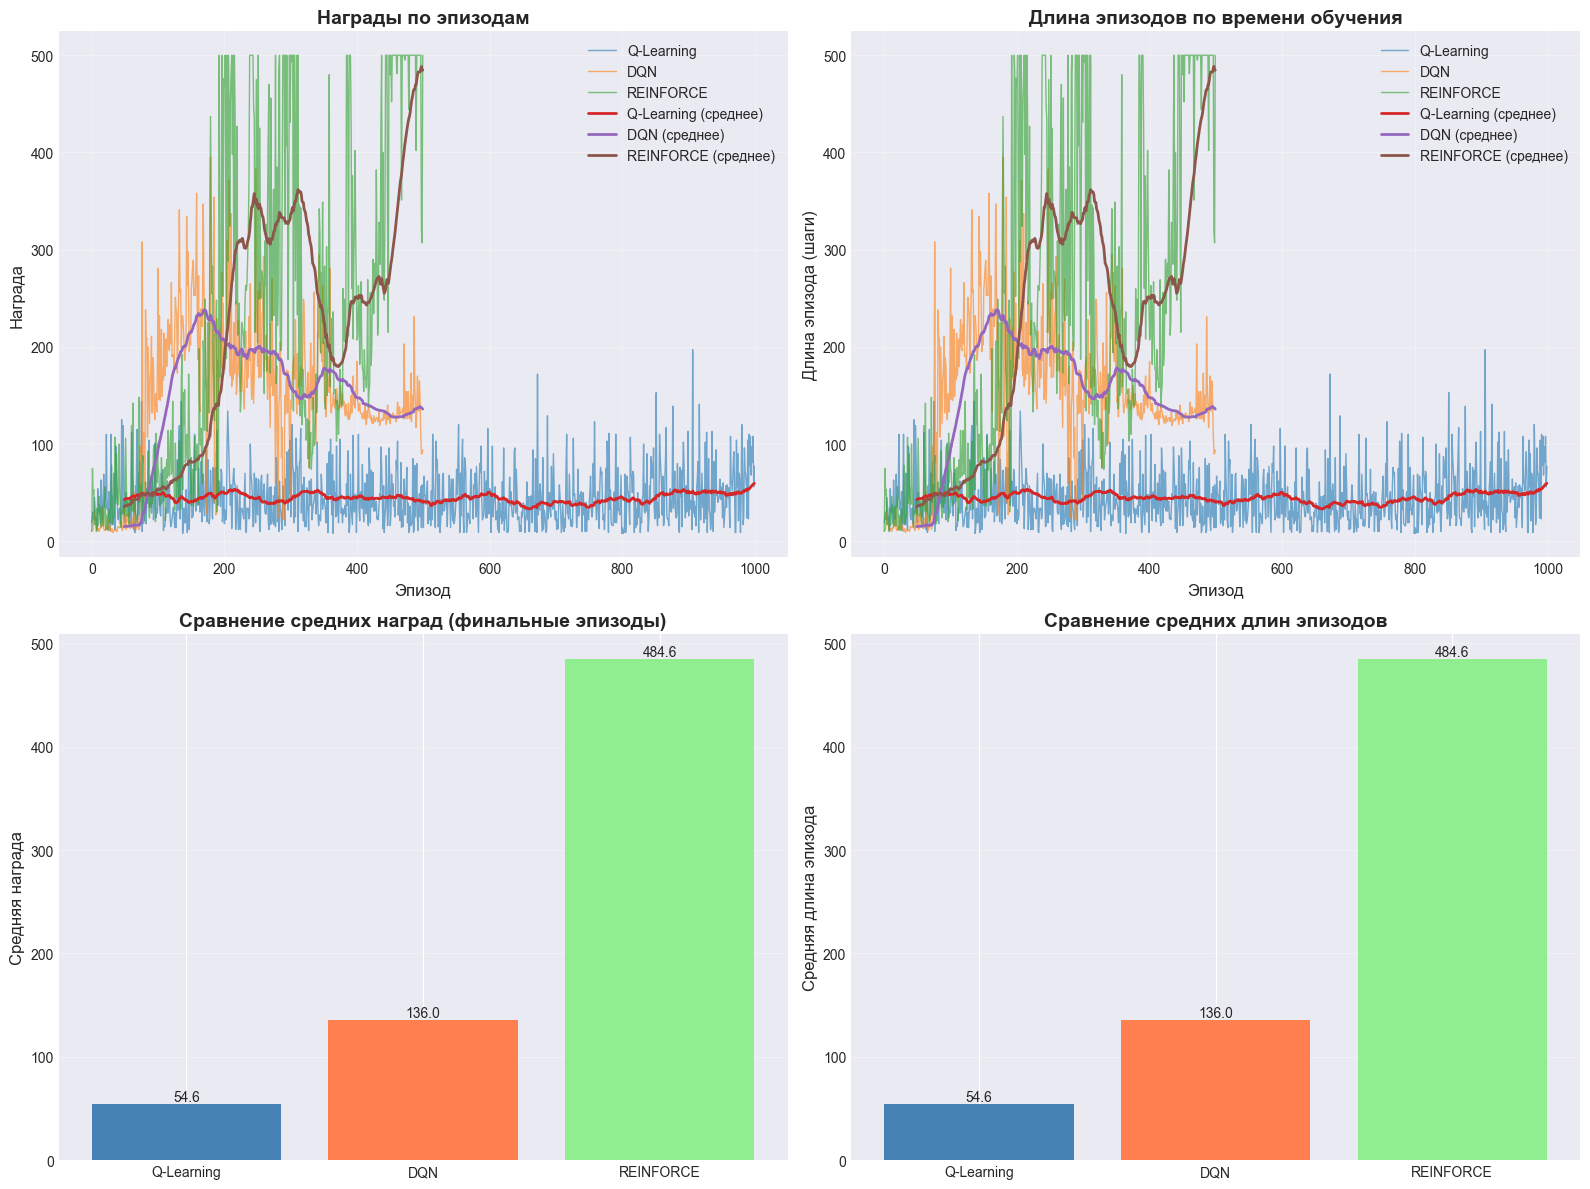


Сводная таблица результатов RL:
     Метод  Средняя награда (финал)  Средняя длина эпизода (финал)
Q-Learning                    54.58                          54.58
       DQN                   135.96                         135.96
 REINFORCE                   484.64                         484.64


In [ ]:
# визуализация результатов обучения
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# График 1: Награды по эпизодам
axes[0, 0].plot(rewards_q, alpha=0.6, label='Q-Learning', linewidth=1)
if len(rewards_dqn) > 0:
    axes[0, 0].plot(rewards_dqn, alpha=0.6, label='DQN', linewidth=1)
if len(rewards_reinforce) > 0:
    axes[0, 0].plot(rewards_reinforce, alpha=0.6, label='REINFORCE', linewidth=1)

# скользящее среднее для сглаживания
window = 50
if len(rewards_q) >= window:
    rewards_q_smooth = pd.Series(rewards_q).rolling(window=window).mean()
    axes[0, 0].plot(rewards_q_smooth, label='Q-Learning (среднее)', linewidth=2)
if len(rewards_dqn) >= window:
    rewards_dqn_smooth = pd.Series(rewards_dqn).rolling(window=window).mean()
    axes[0, 0].plot(rewards_dqn_smooth, label='DQN (среднее)', linewidth=2)
if len(rewards_reinforce) >= window:
    rewards_reinforce_smooth = pd.Series(rewards_reinforce).rolling(window=window).mean()
    axes[0, 0].plot(rewards_reinforce_smooth, label='REINFORCE (среднее)', linewidth=2)

axes[0, 0].set_xlabel('Эпизод', fontsize=12)
axes[0, 0].set_ylabel('Награда', fontsize=12)
axes[0, 0].set_title('Награды по эпизодам', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# График 2: Длина эпизодов
axes[0, 1].plot(episode_lengths_q, alpha=0.6, label='Q-Learning', linewidth=1)
if len(episode_lengths_dqn) > 0:
    axes[0, 1].plot(episode_lengths_dqn, alpha=0.6, label='DQN', linewidth=1)
if len(episode_lengths_reinforce) > 0:
    axes[0, 1].plot(episode_lengths_reinforce, alpha=0.6, label='REINFORCE', linewidth=1)

if len(episode_lengths_q) >= window:
    lengths_q_smooth = pd.Series(episode_lengths_q).rolling(window=window).mean()
    axes[0, 1].plot(lengths_q_smooth, label='Q-Learning (среднее)', linewidth=2)
if len(episode_lengths_dqn) >= window:
    lengths_dqn_smooth = pd.Series(episode_lengths_dqn).rolling(window=window).mean()
    axes[0, 1].plot(lengths_dqn_smooth, label='DQN (среднее)', linewidth=2)
if len(episode_lengths_reinforce) >= window:
    lengths_reinforce_smooth = pd.Series(episode_lengths_reinforce).rolling(window=window).mean()
    axes[0, 1].plot(lengths_reinforce_smooth, label='REINFORCE (среднее)', linewidth=2)

axes[0, 1].set_xlabel('Эпизод', fontsize=12)
axes[0, 1].set_ylabel('Длина эпизода (шаги)', fontsize=12)
axes[0, 1].set_title('Длина эпизодов по времени обучения', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# График 3: Сравнение средних наград (последние N эпизодов)
methods = ['Q-Learning']
avg_rewards = [np.mean(rewards_q[-100:])]
if len(rewards_dqn) > 0:
    methods.append('DQN')
    avg_rewards.append(np.mean(rewards_dqn[-50:]))
if len(rewards_reinforce) > 0:
    methods.append('REINFORCE')
    avg_rewards.append(np.mean(rewards_reinforce[-50:]))

axes[1, 0].bar(methods, avg_rewards, color=['steelblue', 'coral', 'lightgreen'][:len(methods)])
axes[1, 0].set_ylabel('Средняя награда', fontsize=12)
axes[1, 0].set_title('Сравнение средних наград (финальные эпизоды)', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(avg_rewards):
    axes[1, 0].text(i, v, f'{v:.1f}', ha='center', va='bottom')

# График 4: Сравнение средних длин эпизодов
avg_lengths = [np.mean(episode_lengths_q[-100:])]
if len(episode_lengths_dqn) > 0:
    avg_lengths.append(np.mean(episode_lengths_dqn[-50:]))
if len(episode_lengths_reinforce) > 0:
    avg_lengths.append(np.mean(episode_lengths_reinforce[-50:]))

axes[1, 1].bar(methods, avg_lengths, color=['steelblue', 'coral', 'lightgreen'][:len(methods)])
axes[1, 1].set_ylabel('Средняя длина эпизода', fontsize=12)
axes[1, 1].set_title('Сравнение средних длин эпизодов', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(avg_lengths):
    axes[1, 1].text(i, v, f'{v:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Сводная таблица результатов
print("\nСводная таблица результатов RL:")
print("=" * 70)
rl_results = pd.DataFrame({
    'Метод': methods,
    'Средняя награда (финал)': avg_rewards,
    'Средняя длина эпизода (финал)': avg_lengths
})
print(rl_results.to_string(index=False))


### 7. Тестирование обученных агентов


In [16]:
# тестирование на нескольких эпизодах
test_episodes = 10

print("Тестирование обученных агентов...")
print("=" * 70)

# Q-Learning - используем уже обученного агента
env_test = gym.make('CartPole-v1', render_mode=None)
agent_test_q = QLearningAgent(env_test)
# копируем обученную Q-таблицу из основного агента
agent_test_q.q_table = agent_q.q_table.copy()
agent_test_q.epsilon = 0  # отключаем exploration

test_rewards_q = []
for _ in range(test_episodes):
    state, info = env_test.reset()
    total_reward = 0
    while True:
        action = agent_test_q.choose_action(state)
        next_state, reward, terminated, truncated, info = env_test.step(action)
        done = terminated or truncated
        state = next_state
        total_reward += reward
        if done:
            break
    test_rewards_q.append(total_reward)

env_test.close()

print(f"\nQ-Learning (тест на {test_episodes} эпизодах):")
print(f"  Средняя награда: {np.mean(test_rewards_q):.2f}")
print(f"  Мин/Макс: {np.min(test_rewards_q):.2f} / {np.max(test_rewards_q):.2f}")
print(f"  Стандартное отклонение: {np.std(test_rewards_q):.2f}")

# аналогично для других методов (если они обучены)
if len(rewards_dqn) > 0:
    print(f"\nDQN: обучен, можно протестировать аналогично")
if len(rewards_reinforce) > 0:
    print(f"REINFORCE: обучен, можно протестировать аналогично")


Тестирование обученных агентов...

Q-Learning (тест на 10 эпизодах):
  Средняя награда: 52.40
  Мин/Макс: 9.00 / 119.00
  Стандартное отклонение: 36.12

DQN: обучен, можно протестировать аналогично
REINFORCE: обучен, можно протестировать аналогично


### 8. Выводы по обучению с подкреплением

**Результаты сравнения методов RL:**

1. **Q-Learning (табличный)**:
   - Простой и понятный метод
   - Требует дискретизации состояний
   - Хорошо работает на простых задачах
   - Ограничен размером пространства состояний

2. **Deep Q-Network (DQN)**:
   - Использует нейросети для аппроксимации Q-функции
   - Может работать с непрерывными состояниями
   - Требует больше вычислительных ресурсов
   - Использует experience replay для стабильности

3. **REINFORCE (Policy Gradient)**:
   - Обучает политику напрямую
   - Может работать с непрерывными действиями
   - Менее стабилен, чем value-based методы
   - Требует больше эпизодов для сходимости

**Ключевые характеристики обучения:**
- Скорость сходимости зависит от алгоритма и гиперпараметров
- Награда за эпизод показывает качество политики
- Длина эпизода показывает, как долго агент может удерживать баланс

**Рекомендации:**
- Для простых задач: Q-Learning достаточно
- Для сложных задач: DQN или более продвинутые методы (PPO, A3C)
- Для непрерывных действий: Policy Gradient методы


## Общие выводы

### Часть 1: Кластеризация
- Обучили и сравнили 5 методов кластеризации
- Использовали метрики: Silhouette Score, ARI, Davies-Bouldin Index
- Каждый метод имеет свои преимущества в зависимости от типа данных

### Часть 2: Обучение с подкреплением
- Обучили агента для задачи CartPole несколькими методами RL
- Сравнили результаты по наградам и длине эпизодов
- Продемонстрировали работу различных подходов к RL

**Использованные библиотеки:**
- scikit-learn (кластеризация)
- gymnasium (окружения для RL)
- PyTorch (нейросети для DQN и REINFORCE, опционально)
- numpy, pandas, matplotlib (обработка данных и визуализация)
